In [1]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt("/Users/samsuidman/Desktop/neurophysics/advanced_computational_neuroscience/Bert Kappen/Week 3 Take Home/salamander_data.txt")


In [2]:
s_all = data.reshape(160,297,953) # s_all[neurons,experiments,time] gives for all neurons all experiments with all timestamps
learning_rate_w = 0.5 # learning rate for w and theta
learning_rate_m = 0.01 # learning rate for m
eps = 0.05 # error for MF approximation
N = 10 # how many neurons you choose

neurons = np.arange(N) # indices of the first N of the total amount neurons, can also pick random if you want with np.random.randint
s = s_all[neurons,0,:] # s[neurons,patterns] choose 10 neurons and the zero'th experiment 
P = s.shape[1] # amount of patterns (=timestamps) 
s_c = 1/P * np.sum(s,axis=1) # s_c[neurons]     = sum( s[neurons,patterns] ) clamped statistics
ss_c = 1/P * np.matmul(s,np.transpose(s)) # ss_c[neurons,neurons]       = sum( s[neurons,patterns]*s[neurons,patterns]^T ) clamped statistics

# Exact BM
w = np.random.uniform(-0.5,0.5,size=[N,N])
w += np.transpose(w) # make w symmetric
theta = np.random.uniform(-1,1,N)
if N<11:
    T = 50000
    s_exact = np.zeros([T,N])
    ss_exact = np.zeros([T,N,N])
    w_exact = np.zeros([T,N,N]) # needs to be symmetric
    theta_exact = np.zeros([T,N])
    L_exact = np.zeros(T)

    s_every_pattern = np.zeros([N,2**N]) # s_every_pattern[neurons,patterns]
    for i in range(2**N):
        s_every_pattern[:,i] = np.array(list(np.binary_repr(i,width=N))).astype(int) # s_every_pattern[patterns,neurons] stores every possible pattern of N neurons by representing numbers between 0 and 2^N-1 in binary

    for i in range(T):
        s_w_s = np.tensordot(np.tensordot(s_every_pattern,w,axes=(0,0)),s_every_pattern,axes=(1,0)) #s_w_s[patterns,patterns] is a sum over s,w,s for all patterns, you want only the diagonal of this because then you sum over the same pattern.
        theta_s = np.tensordot(theta,s_every_pattern,axes=(0,0)) # theta_s[patterns] sums over all neurons for each pattern
        E = - 0.5*np.diag(s_w_s) - theta_s # calculate E[patterns] for each pattern
        Z = np.sum(np.exp(-E)) # calculate Z by summing over the exponential of E(s) for all patterns
        p = 1/Z * np.exp(-E) # p[patterns] gives the probability of each of the possible patterns of s_every_pattern. Therefore sum(p)=1
        s_i = np.matmul(s_every_pattern,p) # s_i[neurons] free statistic variable
        ss_ij = np.matmul(np.multiply(s_every_pattern,p),np.transpose(s_every_pattern)) # ss_ij[neurons,neurons] free statistic variable
        L = 1/2*np.sum(ss_ij*w) + np.dot(s_i,theta)
        s_exact[i] = s_i
        ss_exact[i] = ss_ij
        w_exact[i] = w
        theta_exact[i] = theta
        L_exact[i] = L
        w += learning_rate_w * (ss_c-ss_ij)
        theta += learning_rate_w * (s_c-s_i)
        if i%100==0:
            print(round(i/T*100,2),"%")
            print(np.max(np.abs(s_c-s_i)))
            print(np.max(np.abs(ss_c-ss_ij)))
            print('\n')
    w = np.random.uniform(-0.5,0.5,size=[N,N])
    w += np.transpose(w) # make w symmetric
    theta = np.random.uniform(-1,1,N)

# MF approximation
T = 10000
s_MF = np.zeros([T,N])
ss_MF = np.zeros([T,N,N])
w_MF = np.zeros([T,N,N])
theta_MF = np.zeros([T,N])
L_MF = np.zeros(T)
for i in range(T):
    m = 0.5*np.ones(N) # m[neurons]
    count = 0
    delta = eps
    while np.max(np.abs(np.tanh(np.matmul(w,m)+theta)-m)) >= eps:
        delta = np.tanh(np.matmul(w,m)+theta)-m
        m += learning_rate_m*delta
        count +=1 
        if np.any(m)<0: 
            m = 0.5*np.ones(N) # m[neurons] 
            print('start over') 
        if count>10000: 
            print(i,np.max(np.abs(np.tanh(np.matmul(w,m)+theta)-m))>eps,np.max(np.abs(np.tanh(np.matmul(w,m)+theta)-m)))
        if count>20000:
            print('break')
            break
    if count>20000:
            break
    s_i = m 
    A = np.diag(1/(1-m**2))-w 
    X = np.linalg.inv(A) 
    ss_ij = X + np.outer(m,m) 
    L = 1/2*np.sum(ss_ij*w) + np.dot(s_i,theta)
    s_MF[i] = s_i
    ss_MF[i] = ss_ij
    w_MF[i] = w
    theta_MF[i] = theta
    L_MF[i] = L
    w += learning_rate_w * (ss_c-ss_ij) 
    theta += learning_rate_w * (s_c-s_i) 
    if i%100==0:
        print(round((i/T*100),2),"%")
        print(np.max(np.abs(s_c-s_i))) 
        print(np.max(np.abs(ss_c-ss_ij)))
        print('\n') 
w = np.random.uniform(-0.5,0.5,size=[N,N])
w += np.transpose(w) # make w symmetric
theta = np.random.uniform(-1,1,N)

# MH sampling
T = 1000
T_MH = 1000
temp = 0.1
s_MH = np.zeros([T,N])
ss_MH = np.zeros([T,N,N])
w_MH = np.zeros([T,N,N])
theta_MH = np.zeros([T,N])
L_MH = np.zeros(T)
E_MH = np.zeros([T,T_MH])
for i in range(T):
    MH_samples = np.zeros([T_MH,N])     
    s = np.random.randint(2,size=N)
    for j in range(T_MH):
        s_old = s.copy()
        n = np.random.randint(N)
        s[n] = 1-s[n] 
        E_old = -1/2*2*s_old[n]*(np.dot(w[n],s_old)-w[n,n]*s_old[n]) - theta[n]*s_old[n]
        E = -1/2*2*s[n]*(np.dot(w[n],s)-w[n,n]*s[n]) - theta[n]*s[n]
        E_MH[i,j] = E
        dE = E-E_old
        a = np.exp(-dE)
        if dE>0 and np.random.rand()>temp:
            s[n] = s_old[n]
        MH_samples[j] = s
    s_i = np.mean(MH_samples,axis=0)
    A = np.diag(1/(1-(s_i*0.9999+0.000001)**2))-w
    X = np.linalg.inv(A) 
    ss_ij = X + np.outer(s_i,s_i) 
    L = 1/2*np.sum(ss_ij*w) + np.dot(s_i,theta)
    s_MH[i] = s_i
    ss_MH[i] = ss_ij
    w_MH[i] = w
    theta_MH[i] = theta
    L_MH[i] = L
    w += learning_rate_w * (ss_c-ss_ij) 
    theta += learning_rate_w * (s_c-s_i) 
    if i%100==0:
        print(round((i/T*100),2),"%")
        print(np.max(np.abs(s_c-s_i))) 
        print(np.max(np.abs(ss_c-ss_ij)))
        print('\n') 


# One time solution
epsilons = np.linspace(0.000001,0.5,100)
L_epsilon = np.zeros(len(epsilons))
for i,epsilon in enumerate(epsilons):
    C = ss_c-np.outer(s_c,s_c) + epsilon*np.diag(np.ones(N))
    w = np.diag(1/(1-m**2)) - np.linalg.inv(C)
    theta = np.arctanh(m) - np.matmul(w,m)
    L = 1/2*np.sum(ss_c*w) + np.dot(s_c,theta)
    L_epsilon[i] = L
    


0.0 %
0.8407394877342007
0.8407394877342007


0.2 %
0.012266339938066487
0.012266339938066476


0.4 %
0.004810863452509044
0.005381744015862078


0.6 %
0.002522707922374542
0.004847513045289039


0.8 %
0.0014823512413936046
0.004346253432627145


1.0 %
0.0009244030041291361
0.0038169095647061294


1.2 %
0.0005982724206552549
0.003420569811711356


1.4 %
0.0005581058314746354
0.003287872082425183


1.6 %
0.0005520850843621951
0.003139813415098139


1.8 %
0.0005376620746019786
0.002977474746316355


2.0 %
0.0005170891454664463
0.0028024668324157934


2.2 %
0.0004923205950303315
0.0026170361876810934


2.4 %
0.00046479686721259683
0.002424055356830157


2.6 %
0.0004355022056425177
0.002226927840336596


2.8 %
0.000405120560627064
0.002029408784408004


3.0 %
0.00037419447924819105
0.0018353462420356713


3.2 %
0.0003432371038656207
0.0017936133579102218


3.4 %
0.00031277874013313153
0.0017708374189079636


3.6 %
0.0002833542339072438
0.0017467512324643298


3.8 %
0.0002554551277728842
0.

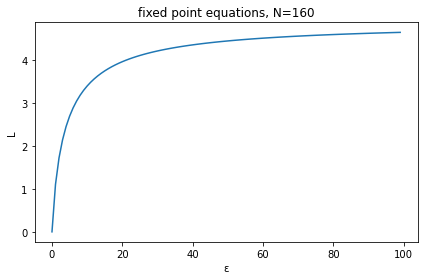

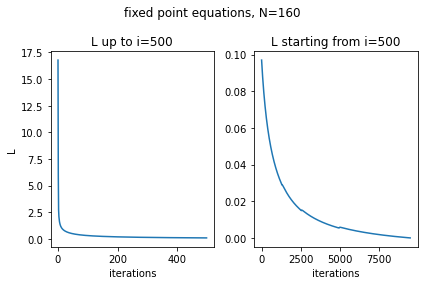

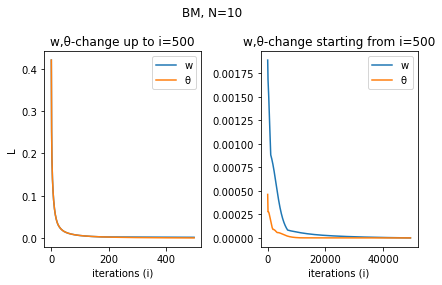

In [3]:
# one time calculation plot for likelhiood
L_method = L_epsilon

fig,ax = plt.subplots()
ax.plot(L_method-np.min(L_method))
ax.set_xlabel('ε') 
ax.set_ylabel('L') 
ax.set_title('fixed point equations, N=160')
fig.tight_layout()

# plot for exact (BM) or MF likelihood
L_method = L_MF # or L_MF
fig,ax = plt.subplots(ncols=2)
ax[0].plot(L_method[:500]-L_method[-1])
ax[0].set_xlabel('iterations') 
ax[0].set_ylabel('L') 
ax[0].set_title('L up to i=500')

ax[1].set_xlabel('iterations') 
ax[1].plot(L_method[500:]-L_method[-1])
ax[1].set_title('L starting from i=500')

fig.suptitle('fixed point equations, N=160')
fig.tight_layout()

# change in w and theta for exact method (but can also be for MF)
w_method = w_exact
theta_method = theta_exact
w_change = np.max(np.abs(np.diff(w_method,axis=0)).reshape(w_method.shape[0]-1,N**2),axis=1)
theta_change = np.max(np.abs(np.diff(theta_method,axis=0)),axis=1)

fig,ax = plt.subplots(ncols=2)
ax[0].plot(w_change[:500]-w_change[-1],label='w')
ax[0].plot(theta_change[:500]-theta_change[-1],label='θ')
ax[0].set_xlabel('iterations (i)') 
ax[0].set_ylabel('L') 
ax[0].set_title('w,θ-change up to i=500')
ax[0].legend()

ax[1].set_xlabel('iterations (i)') 
ax[1].plot(w_change[500:]-w_change[-1],label='w')
ax[1].plot(theta_change[500:]-theta_change[-1],label='θ')
ax[1].set_title('w,θ-change starting from i=500')
ax[1].legend()

fig.suptitle('BM, N=10')
fig.tight_layout()
